In [3]:
!pip install seaborn

In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocations'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='enter urs',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\ayush007\Desktop\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [ ]:
!pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost", username = "root", password = "Ayush@007", database = "ecommerce")

cur = db.cursor()

In [3]:
#list all cities where customers are located

query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [4]:
#Count the number of orders placed in 2017

query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 405909)

In [5]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,1.641833e+08
1,FURNITURE DECORATION,4.633772e+08
2,TELEPHONY,1.577498e+08
3,BED TABLE BATH,5.548674e+08
4,AUTOMOTIVE,2.761434e+08
...,...,...
69,CDS MUSIC DVDS,3.886153e+05
70,LA CUISINE,9.439837e+05
71,FASHION CHILDREN'S CLOTHING,2.545571e+05
72,PC GAMER,7.045153e+05


In [6]:
#Calculate the percentage of orders that were paid in installments

query = """ select ((sum(case when payment_installments >= 1 then 1 else 0 end))/ count(*))*100 from payments  """
cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

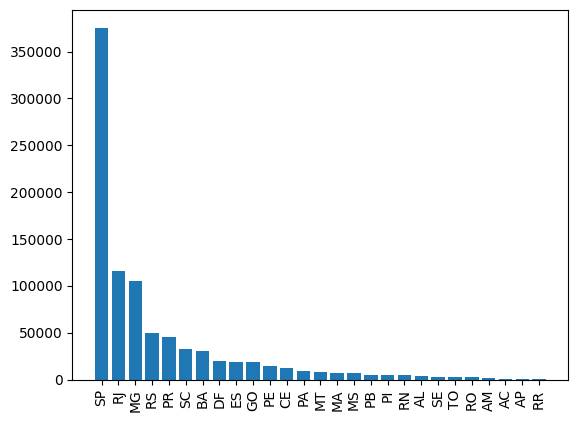

In [7]:
#Count the number of customers from each state

query = """ select customer_state,count(customer_id) from customers group by customer_state   """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['state','no. of customers'])
df = df.sort_values(by = "no. of customers", ascending = False)
plt.bar(df["state"],df["no. of customers"])
plt.xticks(rotation = 90)
plt.show()

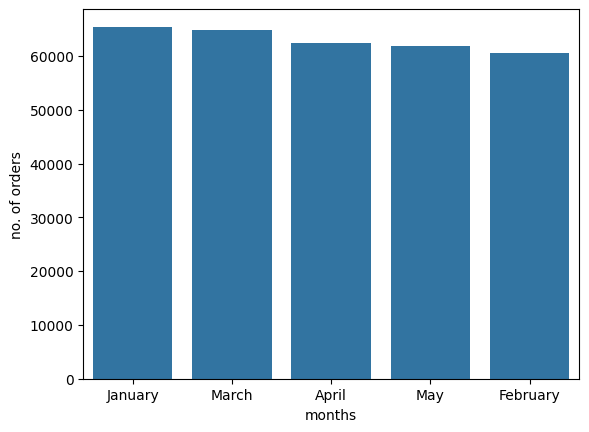

In [8]:
#Calculate the number of orders per month in 2018

query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018 group by months """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['months','no. of orders'])
df = df.sort_values(by = 'no. of orders', ascending = False)
df = df.head()
ax = sns.barplot(x = df["months"],y = df["no. of orders"],data = df)
plt.show()

In [10]:
query4 = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query4)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,577.67
1,HEALTH BEAUTY,559.05
2,COMPUTER ACCESSORIES,534.75
3,FURNITURE DECORATION,482.42
4,WATCHES PRESENT,482.09


In [11]:
#Calculate the total revenue generated by each seller, and rank them by revenue.
query = """ select order_items.seller_id eachseller,round(sum((order_items.price + order_items.freight_value)),2) revenue from order_items
group by eachseller
order by revenue desc;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["each_sellers", "revenue_generated"])
df.head()


,each_sellers,revenue_generated
0,4869f7a5dfa277a7dca6462dcf3b52b2,1497844.19
1,7c67e1448b00f6e969d365cea6b010ab,1437218.65
2,53243585a1d6dc2643021fd1853d8905,1415140.08
3,4a3ca9315b744ce9f8e9374361493884,1413239.77
4,fa1c13f2614d7b5c4749cbc52fecda94,1224508.38


In [12]:
#Identify the correlation between product price and the number of times a product has been purchased.



In [13]:
#Calculate the cumulative sales per month for each year

query = """ select year(orders.order_purchase_timestamp) years,monthname(orders.order_purchase_timestamp) months,Round(sum(payments.payment_value),2) sales from orders
join payments on orders.order_id = payments.order_id
group by years,months
order by years,months;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["YEAR", "MONTH","SALES"])
df


,YEAR,MONTH,SALES
0,2016,December,1059.48
1,2016,October,3190885.92
2,2016,September,13620.96
3,2017,April,22560553.59
4,2017,August,36417401.28
5,2017,December,47433679.91
6,2017,February,15763032.51
7,2017,January,7478354.16
8,2017,July,31988677.65
9,2017,June,27608924.54


In [14]:
#Calculate the year-over-year growth rate of total sales.

query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


In [15]:
# Calculate the moving average of order values for each customer over their order history.

query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
5609839,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
5609840,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
5609841,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
5609842,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


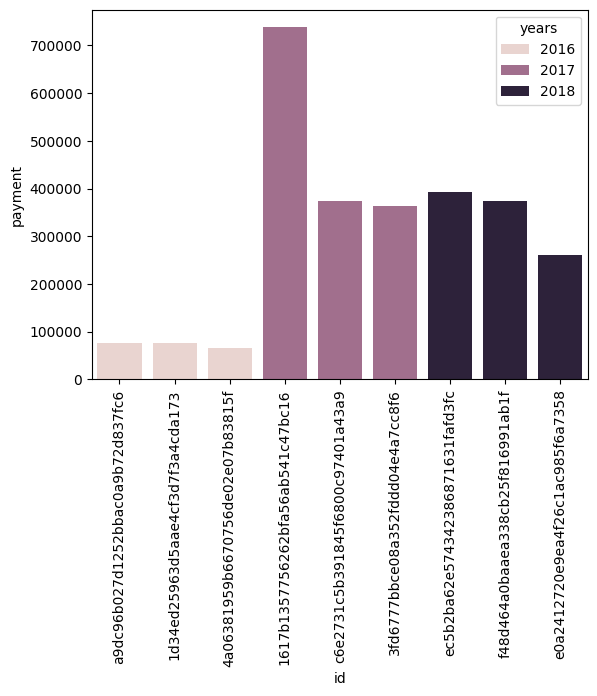

In [18]:
#Identify the top 3 customers who spent the most money in each year.

query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()